### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

In [2]:
data_nights = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/nights_2010-2017.csv', index_col='date')
data_nights = data_nights.drop('Unnamed: 0', axis=1)
data_nights
nights_PAC = data_nights[['nights_PAC']]
nights_PAC.head()

,nights_PAC
date,
2010-01-01,956.88
2010-02-01,1114.93
2010-03-01,1327.84
2010-04-01,1727.31
2010-05-01,2066.52


In [3]:
data_temp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/avgtemp_2010-2017.csv', index_col='date')
data_temp = data_temp.drop('Unnamed: 0', axis=1)
data_temp
avgtemp_PAC = data_temp[['avgtemp_PAC']]
avgtemp_PAC.head()

,avgtemp_PAC
date,
2010-01-01,5.0
2010-02-01,7.0
2010-03-01,9.0
2010-04-01,14.0
2010-05-01,17.0


In [4]:
data_daysoff = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/daysoff_2010-2017.csv', index_col='date')
data_daysoff = data_daysoff.drop('Unnamed: 0', axis=1)
data_daysoff.head()

,daysoff
date,
2010-01-01,11
2010-02-01,9
2010-03-01,9
2010-04-01,10
2010-05-01,12


In [5]:
data_gdp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/regionalGDP_2010-2015.csv', index_col='date')
data_gdp = data_gdp.drop('Unnamed: 0', axis=1)
data_gdp
gdp_PAC = data_gdp[['gdp_PAC']]
gdp_PAC.head()

,gdp_PAC
date,
2010-01-01,143112.575866
2010-02-01,143112.575866
2010-03-01,143112.575866
2010-04-01,143112.575866
2010-05-01,143112.575866


In [6]:
data_PAC = pd.concat([nights_PAC, avgtemp_PAC, data_daysoff, gdp_PAC], axis=1, sort=False)
data_PAC.index = pd.to_datetime(data_PAC.index)
data_PAC_train = data_PAC.dropna(axis=0, how='any')
print(data_PAC_train.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2010-01-01 to 2015-12-01
Data columns (total 4 columns):
nights_PAC     72 non-null float64
avgtemp_PAC    72 non-null float64
daysoff        72 non-null int64
gdp_PAC        72 non-null float64
dtypes: float64(3), int64(1)
memory usage: 2.8 KB
None


### Stationarity check

In [7]:
from statsmodels.tsa.stattools import adfuller

for column in data_PAC_train.columns:
    result = adfuller(data_PAC_train[column])
    print(f'Stationarity test for variable {column}')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] < 0.05:
        print('STATIONARY')
        print(f'{column}')
        print('-------')
    else:
        print('NON-STATIONARY')
        print(f'{column}')
        print('-------')

Stationarity test for variable nights_PAC
ADF Statistic: -2.225807
p-value: 0.197013
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594
NON-STATIONARY
nights_PAC
-------
Stationarity test for variable avgtemp_PAC
ADF Statistic: -0.294483
p-value: 0.926282
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593
NON-STATIONARY
avgtemp_PAC
-------
Stationarity test for variable daysoff
ADF Statistic: -3.149484
p-value: 0.023101
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593
STATIONARY
daysoff
-------
Stationarity test for variable gdp_PAC
ADF Statistic: -1.015064
p-value: 0.747730
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589
NON-STATIONARY
gdp_PAC
-------


Result:
- Nights, AvgTemp, GDP are all non-stationary
- Daysoff is stationary (also doesn't require forecasting as we already have the answers)

#### Figure out which series' seasonality is additive or multiplicative

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# ----- Additive Model below -----

add_data = seasonal_decompose(data_PAC_train, model='additive')  

add_trend = add_data.trend.dropna()
add_seasonal = add_data.seasonal.dropna()
add_residual = add_data.resid.dropna()

# stationarity_test(add_residual)

# ----- Multiplicative Model below -----

mult_data = seasonal_decompose(data_PAC_train, model='multiplicative')  

mult_trend = mult_data.trend.dropna()
mult_seasonal = mult_data.seasonal.dropna()
mult_residual = mult_data.resid.dropna()

# stationarity_test(mult_residual)

In [9]:
from statsmodels.tsa.stattools import acf

add_acfs = add_residual.apply(acf, axis=0).apply(np.square, axis=0).apply(np.sum)

mult_acfs = mult_residual.apply(acf, axis=0).apply(np.square, axis=0).apply(np.sum)

additive = add_acfs < mult_acfs
add_cols = additive.index[additive].tolist()
mult_cols = additive.index[~additive].tolist()
print(add_cols)
print(mult_cols)

['daysoff']
['nights_PAC', 'avgtemp_PAC', 'gdp_PAC']


> Nights, AvgTemp, and GDP are all multiplicative series

<Figure size 432x288 with 0 Axes>

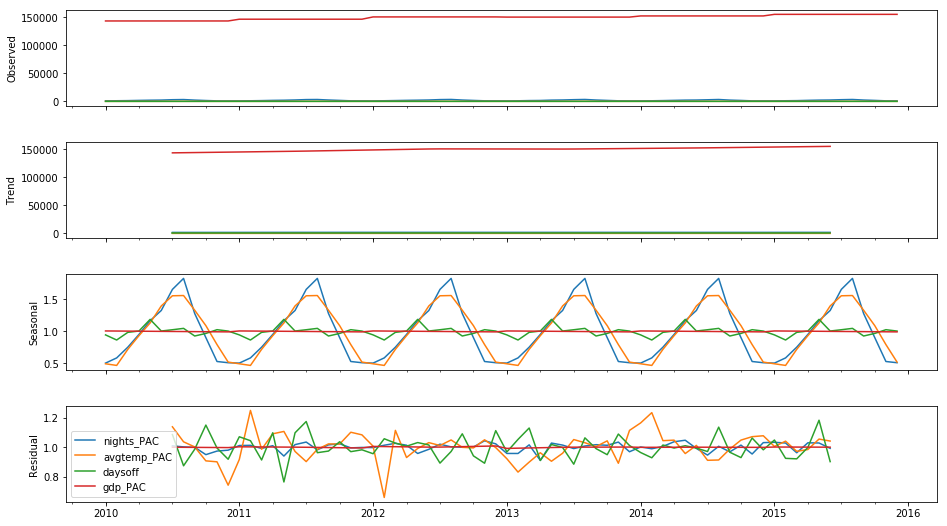

In [10]:
fig = plt.figure()  
fig = mult_data.plot()  
fig.set_size_inches(15, 8)
plt.legend()

### Forecasting the 3 parts: Seasonal, Trend, and Residuals

#### Seasonal forecasts for 2016 (nights only)
- Seasonal naive forecast method: Taking the same seasonal data as 2015

In [11]:
mult_seasonal.tail()

,nights_PAC,avgtemp_PAC,daysoff,gdp_PAC
2015-08-01,1.828675,1.560910,1.047527,0.998023
2015-09-01,1.279591,1.331053,0.928182,0.996701
2015-10-01,0.903177,1.090279,0.968439,0.995384
2015-11-01,0.529655,0.794319,1.027018,0.994073
2015-12-01,0.510644,0.520340,1.005456,0.992765


In [12]:
mult_seasonal_2016 = mult_seasonal[(mult_seasonal.index>='2015-01-01')&(mult_seasonal.index<'2016-01-01')]
mult_seasonal_2016

,nights_PAC,avgtemp_PAC,daysoff,gdp_PAC
2015-01-01,0.504709,0.494060,0.945701,1.007251
2015-02-01,0.585774,0.468400,0.865598,1.005924
2015-03-01,0.753537,0.719867,0.985516,1.004603
2015-04-01,0.952641,0.933739,1.005999,1.003286
2015-05-01,1.167660,1.132058,1.188224,1.001974
2015-06-01,1.327215,1.397917,1.006184,1.000667
2015-07-01,1.656722,1.557059,1.026155,0.999350
2015-08-01,1.828675,1.560910,1.047527,0.998023
2015-09-01,1.279591,1.331053,0.928182,0.996701
2015-10-01,0.903177,1.090279,0.968439,0.995384


#### Trend forecasts for 2016 (nights only)
- non-seasonal forecasting methods ex. ARIMA or Holt's

In [13]:
mult_trend.head()

,nights_PAC,avgtemp_PAC,daysoff,gdp_PAC
2010-07-01,1769.145833,14.666667,9.875000,143242.681530
2010-08-01,1765.466667,14.833333,9.833333,143502.892859
2010-09-01,1764.709167,15.000000,9.833333,143763.104187
2010-10-01,1767.228333,15.166667,9.875000,144023.315516
2010-11-01,1766.691667,15.375000,9.791667,144283.526845


In [14]:
from pyramid.arima import auto_arima
arima_trend = auto_arima(np.array(mult_trend.nights_PAC), start_p=0, start_q=0, max_p=20, max_q=20, m=12,
                    start_P=0, max_P=20, seasonal=False, d=1, D=1, trace=True,
                    error_action='ignore', suppress_warnings=True, stepwise=False, random=True, random_state=42) 

arima_trend.summary()


Fit ARIMA: order=(6, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(8, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=386.432, BIC=390.587, Fit time=0.007 seconds
Fit ARIMA: order=(5, 1, 0); AIC=333.072, BIC=347.615, Fit time=0.205 seconds
Fit ARIMA: order=(0, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(9, 1, 0); AIC=337.305, BIC=360.158, Fit time=1.099 seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1); AIC=327.398, BIC=335.708, Fit time=0.141 seconds
Fit ARIMA: order=(10, 1, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 0); AIC=338.841, BIC=349.229, Fit time=0.132 seconds
Total fit time: 1.654 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -159.699
Method:                       css-mle   S.D. of innovations              3.480
Date:                Sun, 19 Aug 2018   AIC                            327.398
Time:                        21:00:49   BIC                            335.708
Sample:                             1   HQIC                           330.642
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1898      1.382      0.861      0.393      -1.518       3.898
ar.L1.D.y      0.3554      0.121      2.943      0.005       0.119       0.592
ma.L1.D.y      0.9999      0.067     14.886      0.000       0.868       1.132
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.8134           +0.0000j            2.8134            0.0000
MA.1           -1.0001           +0.0000j            1.0001            0.5000
-----------------------------------------------------------------------------
"""

In [15]:
arima_trend.fit(mult_trend.nights_PAC)


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [16]:
arima_trend_forecast_2016 = arima_trend.predict(n_periods=12)
arima_trend_forecast_2016

array([1846.45350717, 1846.792287  , 1847.67958289, 1848.76184506,
       1849.91340664, 1851.08960023, 1852.2745491 , 1853.46260997,
       1854.65177698, 1855.84133717, 1857.0310371 , 1858.2207867 ])

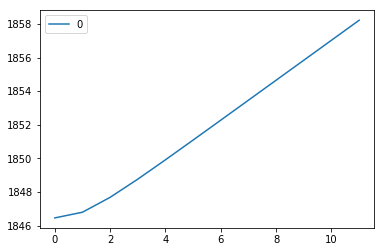

In [17]:
arima_trend_forecast_2016_df = pd.DataFrame(arima_trend_forecast_2016)
arima_trend_forecast_2016_df.plot()

#### Residual forecasts for 2016 (produces forecasts for all but we will use nights forecast only)
- VAR model
- Takes all variables into account and gives predictions for all
- We will be taking the VAR prediction for nights_PAC only

In [18]:
mult_residual.head()

,nights_PAC,avgtemp_PAC,daysoff,gdp_PAC
2010-07-01,1.008754,1.138510,1.085532,0.999742
2010-08-01,1.002161,1.036560,0.873729,0.999256
2010-09-01,0.999191,1.001714,0.986072,0.998770
2010-10-01,0.949383,0.907118,1.150226,0.998284
2010-11-01,0.973639,0.900706,0.994409,0.997799


In [39]:
from statsmodels.tsa.api import VAR, DynamicVAR

model = VAR(mult_residual, dates=mult_residual.index)

# lagorder_results = model.select_order(12)
# print(lagorder_results.summary())

results = model.fit(maxlags=11, ic='aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 19, Aug, 2018
Time:                     21:01:45
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -34.8682
Nobs:                     49.0000    HQIC:                  -39.1811
Log likelihood:           926.424    FPE:                1.35615e-16
AIC:                     -41.8178    Det(Omega_mle):     1.00134e-17
--------------------------------------------------------------------
Results for equation nights_PAC
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                 -13.477490         6.522741           -2.066           0.039
L1.nights_PAC          -0.130783         0.341090           -0.383           0.701
L1.avgtemp_PAC         -0.008648         0.0583

/Users/jinny/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [20]:
lag_order = results.k_ar
print(lag_order)

mult_resid_forecast_2016 = results.forecast(mult_residual.values[-lag_order:], 12)
mult_resid_forecast_2016

11


array([[1.01779952, 0.99359299, 1.05942543, 1.00062402],
       [0.99694245, 1.08346393, 0.94286745, 0.99962199],
       [0.9954525 , 1.04726294, 0.94884353, 0.99882955],
       [0.97867523, 0.991415  , 1.1102652 , 0.99859344],
       [0.96637076, 0.92151182, 0.96162506, 1.00091983],
       [1.0112017 , 0.77738818, 0.93841724, 1.00118098],
       [1.03624578, 0.96127179, 1.04021945, 1.0042267 ],
       [1.00986491, 1.06565244, 1.08542012, 1.0010574 ],
       [0.9669747 , 1.03206409, 0.91446888, 1.00000298],
       [1.01510209, 1.02696452, 1.06435238, 1.00045568],
       [0.9730436 , 1.08405881, 0.83922206, 1.00259277],
       [1.01633206, 1.01413695, 1.01681212, 0.9994195 ]])

In [21]:
mult_resid_forecast_2016_df = pd.DataFrame(mult_resid_forecast_2016)
mult_resid_forecast_2016_df

,0,1,2,3
0,1.017800,0.993593,1.059425,1.000624
1,0.996942,1.083464,0.942867,0.999622
2,0.995452,1.047263,0.948844,0.998830
3,0.978675,0.991415,1.110265,0.998593
4,0.966371,0.921512,0.961625,1.000920
5,1.011202,0.777388,0.938417,1.001181
6,1.036246,0.961272,1.040219,1.004227
7,1.009865,1.065652,1.085420,1.001057
8,0.966975,1.032064,0.914469,1.000003
9,1.015102,1.026965,1.064352,1.000456


#### Putting the decomposed forecasts back together (multiplicative; nights only)

In [22]:
mult_seasonal_2016_array = mult_seasonal_2016.nights_PAC.values
mult_seasonal_2016_df = pd.DataFrame(mult_seasonal_2016_array)
mult_seasonal_2016_df.head(2)


,0
0,0.504709
1,0.585774


### 2016 Nights forecast

In [23]:
forecast_2016 = mult_seasonal_2016_df[0] * arima_trend_forecast_2016_df[0] * mult_resid_forecast_2016_df[0]
forecast_2016

0      948.508624
1     1078.495795
2     1385.964293
3     1723.648234
4     2087.428929
5     2484.313688
6     3179.931119
7     3422.816415
8     2294.820282
9     1701.466886
10     957.071912
11     964.387052
Name: 0, dtype: float64

#### Actual values for 2016

In [24]:
nights_PAC_2016 = data_PAC[(data_PAC.index>='2016-01-01')&(data_PAC.index<'2017-01-01')]
nights_PAC_2016 = np.array(nights_PAC_2016.nights_PAC)
nights_PAC_2016_df = pd.DataFrame(nights_PAC_2016)
nights_PAC_2016_df.head(2)

,0
0,956.28
1,1141.47


### Compare with real number of nights in 2016

#### AIC for 2016 forecast

In [25]:
results.aic

-41.817774481635546

#### MASE for 2016 forecast

#### Function to calculate seasonal MASE
- Doesn't work properly in this specific case as forecast includes only 12 months of data into the future

In [26]:
# Define seasonality as 12 (monthly data) in argument when ground truth data includes at least 24 months

def seasonal_MASE(truth, forecast, seasonality=1):    
    period = truth.shape[0] # T
    # print(period)
    forecast_errors = np.abs(truth - forecast)
    # print(forecast_errors)
    mean_absolute_forecast_error = np.sum(forecast_errors) / period
    # print(mean_absolute_forecast_error)

    naive_period = truth.shape[0] - seasonality # T - m
    # print(naive_period)
    # print(truth[seasonality:])
    # print(truth[:period - seasonality])
    naive_errors = np.abs(truth[seasonality:] - truth[:period - seasonality])
    mean_absolute_naive_error = np.sum(naive_errors) / naive_period
    
    return mean_absolute_forecast_error / mean_absolute_naive_error

#### MASE for 2016 forecast

$$
\text{MASE} = \dfrac{\text{MAE}(\text{our method})}{\text{MAE}(\text{seasonal naive})}
$$

- How good our predictions are compared to the simplest model possible (seasonal naive)
- MAE is compared between the two models (our model and seasonal naive model)
- A seasonal naive model repeats the same value from the last period
    - ex. Oct 2015 had 540 nights so seasonal naive thinks Oct 2016 will have 540 nights as well
    - At MASE = 1, it means the predictions are just as good as a seasonal naive model
    
Goal: We want to have an MASE much less than 1

**MASE for our 2016 forecast** tells us that the error of our model is 25% of the seasonal naive model's error
> This means *4 times less error* than the seasonal naive model's error

In [27]:
MASE_2016 = seasonal_MASE(nights_PAC_2016, forecast_2016)
print('MASE: %f' % MASE_2016)

MASE: 0.253320


#### RMSE and MAE for 2016 forecast
- RMSE: For a given month, our 2016 forecast is usually off by about 140 hotel nights (give or take)
    - RMSE is sensitive to large errors because the error of each wrong prediction is squared


- MAE: For a given month, out 2016 forecast is usually off by about 96 hotel nights (give or take)
    - MAE doesn't penalize large errors (unlike RMSE), it gives equal weight to all kinds of errors

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_2016 = np.sqrt(mean_squared_error(nights_PAC_2016, forecast_2016))
mae_2016 = mean_absolute_error(nights_PAC_2016, forecast_2016)
rmse_2016, mae_2016

(140.63403519776654, 96.91500164983468)

#### Predictions vs. Ground truth for Hotel nights PAC 2016

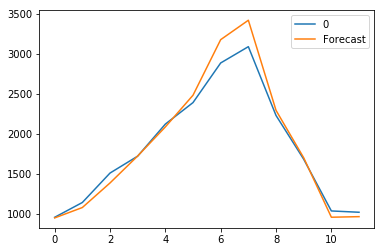

In [29]:
nights_PAC_2016_df.plot(label='Real')
forecast_2016.plot(label='Forecast')
plt.legend()

### Extra - 2017 forecast comparison

In [30]:
mult_resid_forecast_2017 = results.forecast(mult_residual.values[-lag_order:], 24)
mult_resid_forecast_2017_df = pd.DataFrame(mult_resid_forecast_2017)
mult_resid_forecast_2017_df.head()

,0,1,2,3
0,1.017800,0.993593,1.059425,1.000624
1,0.996942,1.083464,0.942867,0.999622
2,0.995452,1.047263,0.948844,0.998830
3,0.978675,0.991415,1.110265,0.998593
4,0.966371,0.921512,0.961625,1.000920


In [31]:
# Same seasonal values as 2015
mult_seasonal_2016_df.head()

,0
0,0.504709
1,0.585774
2,0.753537
3,0.952641
4,1.167660


In [32]:
arima_trend_forecast_2017 = arima_trend.predict(n_periods=24)
arima_trend_forecast_2017_df = pd.DataFrame(arima_trend_forecast_2017)
arima_trend_forecast_2017_df.head()

,0
0,1846.453507
1,1846.792287
2,1847.679583
3,1848.761845
4,1849.913407


In [33]:
nights_PAC_2017 = data_PAC[(data_PAC.index>='2017-01-01')&(data_PAC.index<'2017-12-02')]
nights_PAC_2017 = np.array(nights_PAC_2017.nights_PAC)
nights_PAC_2017_df = pd.DataFrame(nights_PAC_2017)
nights_PAC_2017_df.head()

,0
0,1000.33
1,1148.06
2,1409.69
3,2011.76
4,2092.09


In [34]:
nights_resid_2017 = mult_resid_forecast_2017_df[0][12:24]
forecast_2017 = mult_seasonal_2016_df[0].values * arima_trend_forecast_2017_df[12:24].values.transpose()[0] * nights_resid_2017.values.transpose()
forecast_2017_df = pd.Series(forecast_2017.transpose())
forecast_2017_df

0      951.379573
1     1081.717169
2     1418.559845
3     1809.919582
4     2132.830487
5     2410.677844
6     3071.550715
7     3347.361214
8     2505.290423
9     1702.957604
10     968.919851
11     970.173610
dtype: float64

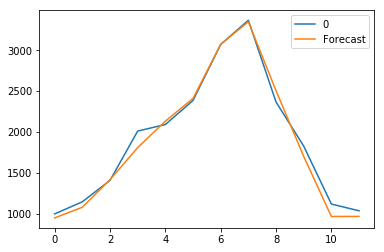

In [35]:
nights_PAC_2017_df.plot(label='Real')
forecast_2017_df.plot(label='Forecast')
plt.legend()

In [36]:
MASE_2017 = seasonal_MASE(nights_PAC_2017, forecast_2017)
print('MASE: %f' % MASE_2017)

MASE: 0.175012


In [37]:
rmse_2017 = np.sqrt(mean_squared_error(nights_PAC_2017, forecast_2017))
mae_2017 = mean_absolute_error(nights_PAC_2017, forecast_2017)
rmse_2017, mae_2017

(96.98017186731838, 74.6550593840514)